In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Behavior of Single Modes

Smoothing takes a long time to converge to the solution.  To understand why this is, we
will look at the behavior of a single frequency mode under relaxation.  We'll use
the Laplace equation:

$$\phi^{\prime\prime} = 0$$

on $[0, 1]$ with homogeneous BCs as our test case.

The solution to this is trivial&mdash;$\phi = 0$.

So if we initialize the solution with a single-frequency sine way, and smooth a bit, we can compute the error easily.

We'll use the same grid class and `smooth` function as before.  To make it easier,
they are in a module now that we can import

In [2]:
import smoothing

We'll set our initial conditions like

$$\phi^{(0)} = \sin(2\pi m x)$$

where $m$ is an integer.

Let's see how different modes behave.  We'll write a function that makes a plot of the solution after several different numbers of iterations

In [3]:
def single_mode_comparison(m=1, nx=128):
    g = smoothing.Grid(nx)
    
    fig = plt.figure()
    fig.set_size_inches(8, 8)
    
    ax = fig.add_subplot(111)
    
    for niter in [1, 10, 100, 1000]:
        # initialize
        g.phi = np.sin(2*np.pi*m*g.x)
        
        # smooth
        smoothing.relax(g, tol=None, max_iters=niter)
        
        ax.plot(g.x[g.ilo:g.ihi+1], g.phi[g.ilo:g.ihi+1],
                label=f"{niter} iters")
        
    ax.legend()
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\phi(x)$")
    return fig

Let's look at the behavior of $m=1$

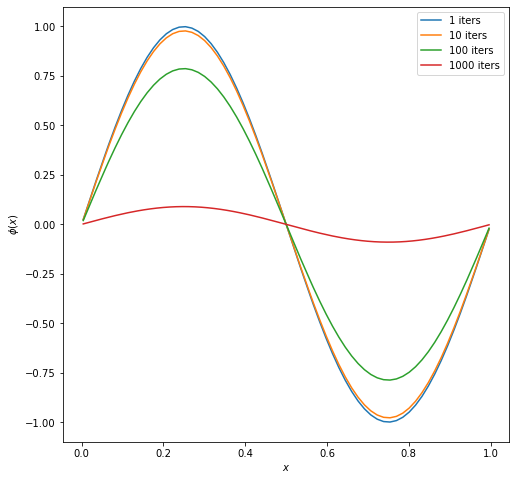

In [4]:
fig = single_mode_comparison(m=1)

We know that the solution is just $\phi = 0$, so any departure from that is error.  Even after 1000 iterations we can still see the sine behavior of the initial guess, so this is converging very slowly.

What about a higher mode? $m = 5$

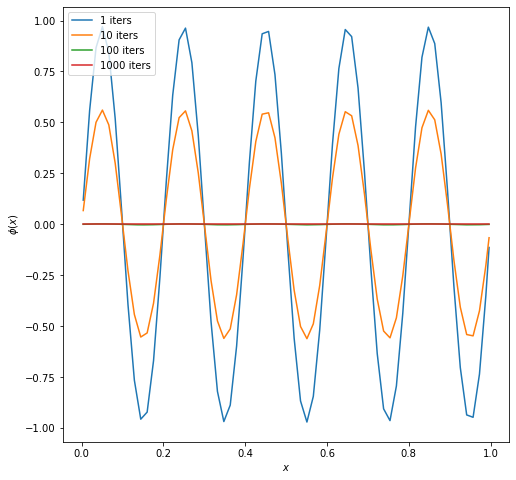

In [5]:
fig = single_mode_comparison(m=5)

This converges much faster!  After 100 iterations, it is hard to see the departure from $\phi = 0$

What about $m = 10$?

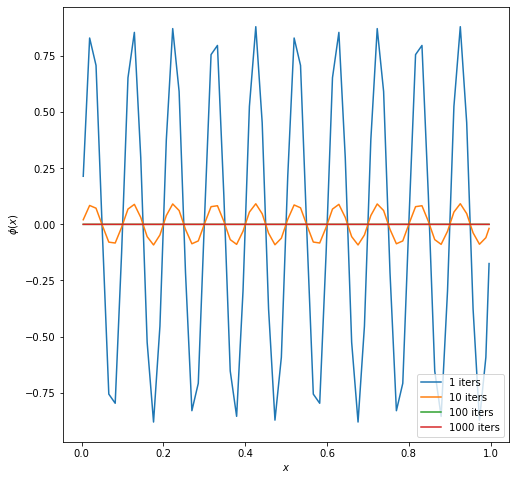

In [6]:
fig = single_mode_comparison(m=10)

This converges really fast!

## Elements of Multigrid

What we are seeing is that the long wavelength modes take a long time to relax away while the short wavelength modes relax very quickly.  Now, for this problem, this is the error, and the Poisson equation is linear, so we can decompose $\phi(x)$ into its Fourier modes and what we observed above tells us that the short wavelength error modes will go away quickly (few smoothing iterations) while the long wavelength error modes will take much longer to relax away.

To see this, lets seed all 3 modes and look at how they relax:

Text(0, 0.5, '$\\phi(x)$')

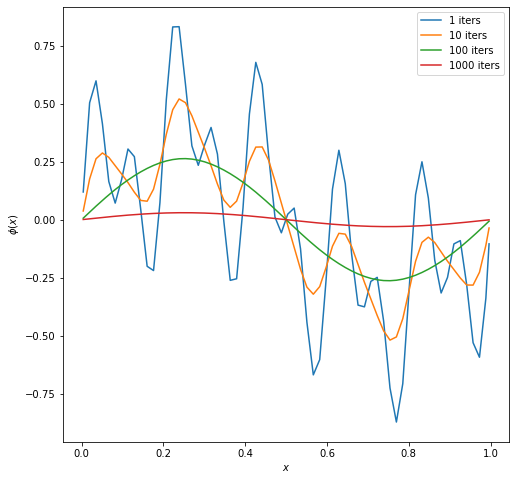

In [7]:
g = smoothing.Grid(128)
    
fig = plt.figure()
fig.set_size_inches(8, 8)
    
ax = fig.add_subplot(111)
    
for niter in [1, 10, 100, 1000]:
    # initialize
    g.phi = 1./3. * (np.sin(2*np.pi*g.x) +
                     np.sin(2*np.pi*5*g.x) +
                     np.sin(2*np.pi*10*g.x))
        
    # smooth
    smoothing.relax(g, tol=None, max_iters=niter)
        
    ax.plot(g.x[g.ilo:g.ihi+1], g.phi[g.ilo:g.ihi+1],
            label=f"{niter} iters")
        
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$\phi(x)$")

After 10 iterations, only the 2 longest wavelength modes persist and after 100, only the m = 1 mode survives.

The *multigrid* algorithm exploits this behavior by recognizing that a long wavelength error on the original grid will have a shorter wavelength (in terms of number of zones across a wavelength) on a coarser grid.  So multigrid coarsens the problem to accelerate the convergence of long wavelength errors.

To see this, let's look at an $m=2$ mode at several different grid resolutions.

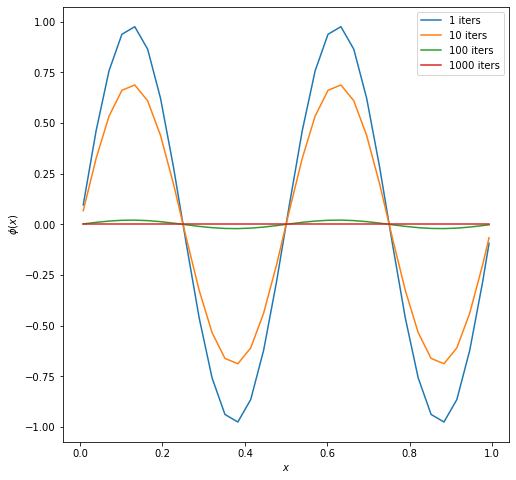

In [8]:
fig = single_mode_comparison(m=2, nx=64)

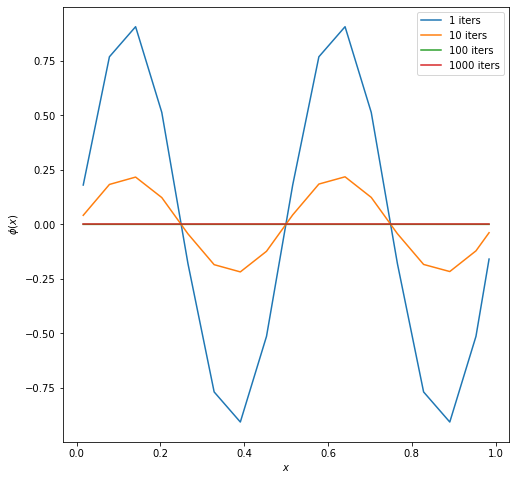

In [9]:
fig = single_mode_comparison(m=2, nx=32)

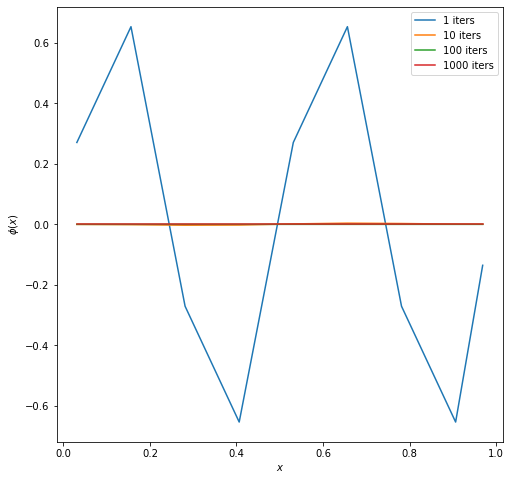

In [10]:
fig = single_mode_comparison(m=2, nx=16)

Notice that with 64 zones, the $m=2$ mode takes a long time to smooth away.  But as we make the grid coarser, that same mode smooths away much faster.  On the coarse grid, its wavelength, in terms of number of zones, is smaller, so fewer iterations are needed to communicate across the mode.

To build a multigrid algorithm we need a way to coarsen our problem and then bring what we learned on the coarse grid back up to the fine grid.  We'll work on that next.